# Implementing Maximum Likelihood and Bayes Estimators

George Ho 9/21/17

This notebook illustrates maximum likelihood and Bayesian estimation.

We consider three scenarios:
 - Estimating the binomial probability $p$ in a $B(n, p)$ model, where $n$ is known
 - Estimating the mean $\mu$ in an $N(\mu, \sigma^2)$ model, where $\sigma^2$ is known
 - Estimating the precision $\tau$ in an $N(\mu, 1/\tau)$ model, where $\mu$ is known

In each scenario, three prior distributions are considered and plotted. Each prior, as well as the maximum likelihood estimator, is used to do an online inference of the relevant parameter. The mean squared error is then plotted for all three priors, as well as the maximum likelihood estimator. Finally, the posterior distribution is plotted at various points in the online inference.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

## Beta-Binomial (estimating binomial probability $p$)

### Making data

In [2]:
# Ground truth
p = 0.3
n = 10
data_size = 100

# Observations
X = np.random.binomial(n, p, data_size)

# Number of samples used to plot histograms
hist_size = 10000

### Plotting priors

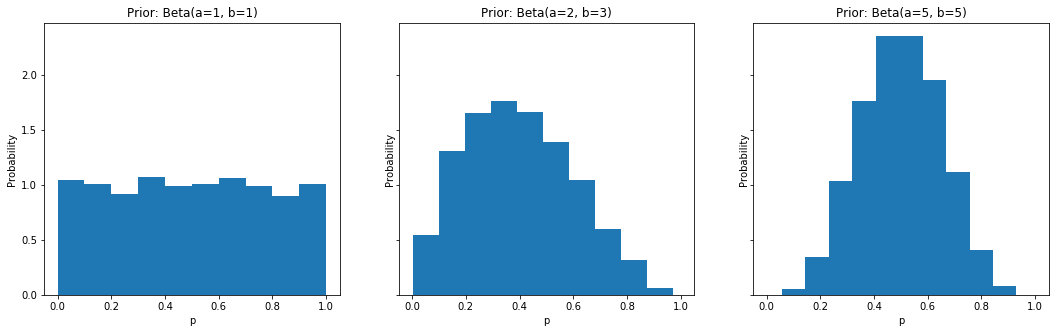

In [3]:
# Three sets of hyperparameters
hyperparams = [(1, 1), (2, 3), (5, 5)]

fig, axarr = plt.subplots(nrows=1, ncols=len(hyperparams), figsize=[18, 5], sharex=True, sharey=True)
priors = np.empty(shape=[hist_size, len(hyperparams)])

for i, ((a, b), ax) in enumerate(zip(hyperparams, axarr)):
    priors[:, i] = np.random.beta(a=a, b=b, size=hist_size)
    ax.hist(priors[:, i], normed=1)
    ax.set_title("Prior: Beta(a={0}, b={1})".format(a, b))
    ax.set_ylabel("Probability")
    ax.set_xlabel("p")

plt.show()

### MAP and ML estimation

In [4]:
# MAP
map_params = np.empty(shape=[len(X)+1, len(hyperparams)*len(hyperparams[0])])
map_params[0,:] = list(itertools.chain(*hyperparams))

for i, x in enumerate(X):
    # Update rule for binomial model with beta prior for p
    map_params[i+1, :] = map_params[i, :] + np.tile([x, n-x], 3)

# Expectation of Beta(a,b) = a/(a+b)
map_ests = (map_params[:, ::2] / (map_params[:, ::2] + map_params[:, 1::2]))

In [5]:
# ML
ml_ests = np.empty(shape=[len(X), 1])

for i in range(len(X)):
    # Mean of observations
    ml_ests[i] = np.mean(X[:i+1]/n)

### Plotting mean squared error

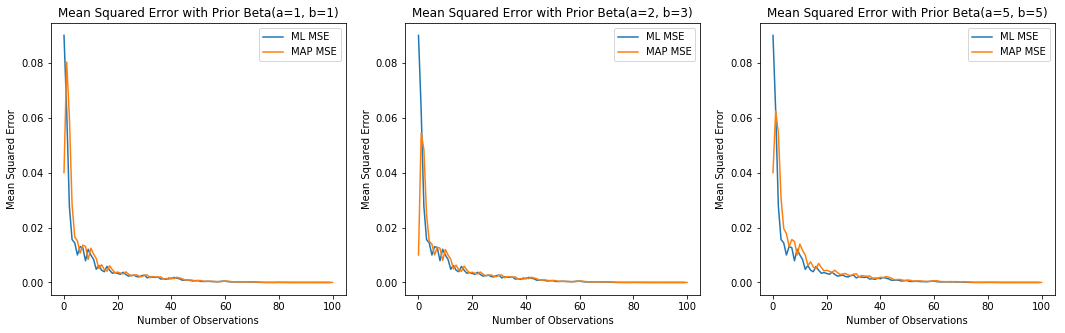

In [6]:
fig, axarr = plt.subplots(nrows=1, ncols=len(hyperparams), figsize=[18, 5], sharex=True)
ml_mean_sq_err = (ml_ests - p)**2
map_mean_sq_err = (map_ests - p)**2

for i, (ax, (a, b)) in enumerate(zip(axarr, hyperparams)):
    ax.plot(ml_mean_sq_err, label='ML MSE')
    ax.plot(map_mean_sq_err[:, i], label='MAP MSE')
    ax.set_title("Mean Squared Error with Prior Beta(a={0}, b={1})".format(a, b))
    ax.legend()
    ax.set_ylabel("Mean Squared Error")
    ax.set_xlabel("Number of Observations")

plt.show()

### Plotting posteriors for various observations

We use the first set of hyperparameters in `hyperparams` (i.e. a $Beta(1, 1)$ prior) to illustrate this.

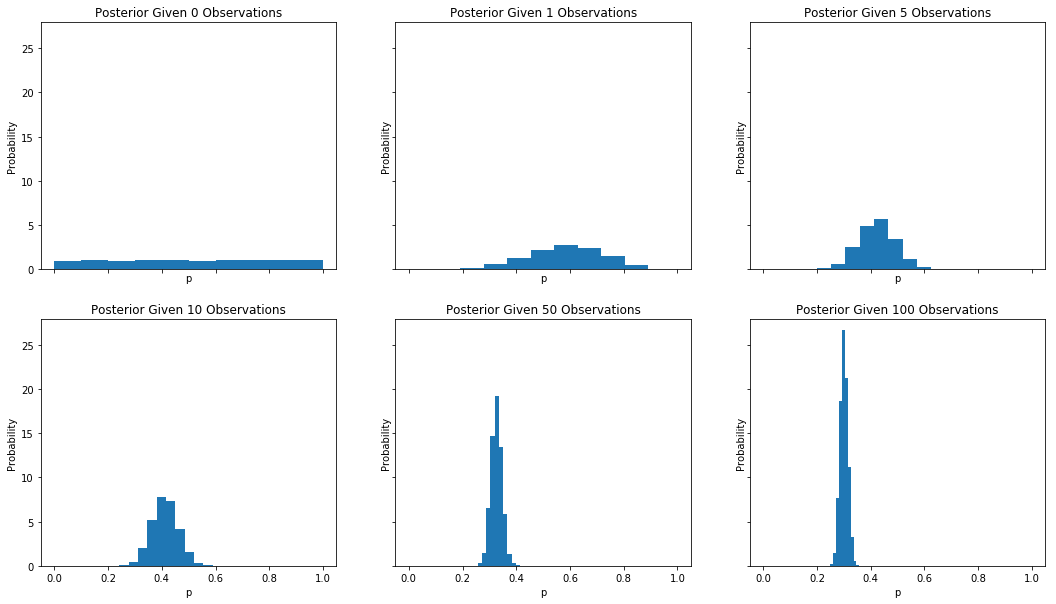

In [7]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=[18, 10], sharex=True, sharey=True)
num_obs = [0, 1, 5, 10, 50, 100]

for i, (num, ax) in enumerate(zip(num_obs, axarr.flatten())):
    samp = np.random.beta(a=map_params[num, 0], b=map_params[num, 1], size=hist_size)
    ax.hist(samp, normed=True)
    ax.set_title("Posterior Given {} Observations".format(num))
    ax.set_ylabel("Probability")
    ax.set_xlabel("p")
    
plt.show()

## Gaussian with Known Variance (estimating mean $μ$)

### Making data

In [8]:
# Ground truth
mu = -1
sigma = 4
data_size = 100

# Observations
X = np.random.normal(loc=mu, scale=sigma, size=data_size)

# Number of samples used to plot histograms
hist_size = 10000

### Plotting priors

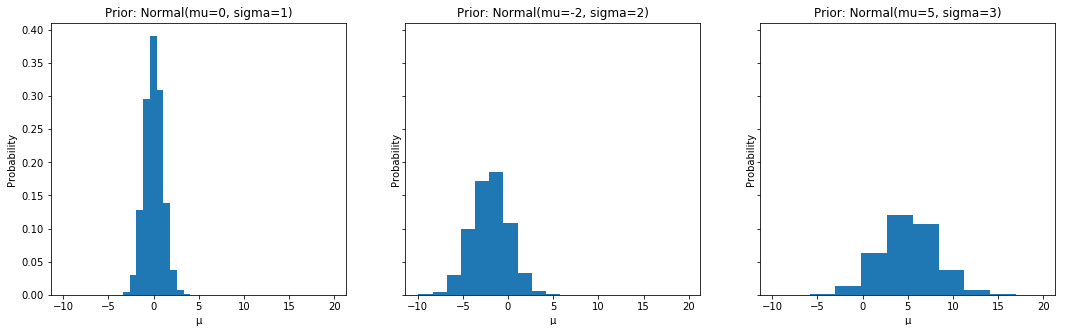

In [9]:
# Three sets of hyperparameters
hyperparams = [(0, 1), (-2, 2), (5, 3)]

fig, axarr = plt.subplots(nrows=1, ncols=len(hyperparams), figsize=[18, 5], sharex=True, sharey=True)
priors = np.empty(shape=[hist_size, len(hyperparams)])

for i, ((mu_0, sigma_0), ax) in enumerate(zip(hyperparams, axarr)):
    priors[:, i] = np.random.normal(loc=mu_0, scale=sigma_0, size=hist_size)
    ax.hist(priors[:, i], normed=True)
    ax.set_title("Prior: Normal(mu={0}, sigma={1})".format(mu_0, sigma_0))
    ax.set_ylabel("Probability")
    ax.set_xlabel("μ")

plt.show()

### MAP and ML estimation

In [10]:
# MAP
map_params = np.zeros(shape=[len(X)+1, len(hyperparams)*len(hyperparams[0])])
map_params[0,:] = list(itertools.chain(*hyperparams))

for i, x in enumerate(X):
    # Update rule for normal model with normal prior for mu. Online learning.
    coeff = sigma**2 / (map_params[i, 1::2]**2 + sigma**2)
    map_params[i+1, ::2] = coeff*map_params[i, ::2] + (1-coeff)*x
    map_params[i+1, 1::2] = np.sqrt(1/(1/(map_params[i, 1::2]**2) + 1/sigma**2))

# Expectation of N(mu, sigma^2) = mu
map_ests = map_params[:, ::2]

In [11]:
# ML
ml_ests = np.empty(shape=[len(X), 1])

for i in range(len(X)):
    ml_ests[i] = np.mean(X[:i+1])

### Plotting mean squared error

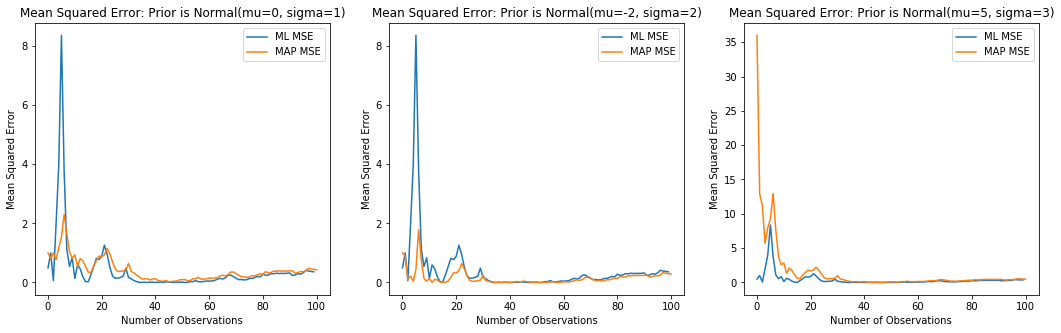

In [12]:
fig, axarr = plt.subplots(nrows=1, ncols=len(hyperparams), figsize=[18, 5], sharex=True)
ml_mean_sq_err = (ml_ests - mu)**2
map_mean_sq_err = (map_ests - mu)**2

for i, (ax, (mu_0, sigma_0)) in enumerate(zip(axarr, hyperparams)):
    ax.plot(ml_mean_sq_err, label='ML MSE')
    ax.plot(map_mean_sq_err[:, i], label='MAP MSE')
    ax.set_title("Mean Squared Error: Prior is Normal(mu={0}, sigma={1})".format(mu_0, sigma_0))
    ax.legend()
    ax.set_ylabel("Mean Squared Error")
    ax.set_xlabel("Number of Observations")

plt.show()

### Plotting posteriors for various observations

We use the first set of hyperparameters in `hyperparams` (i.e. a $N(0, 1)$ prior) to illustrate this.

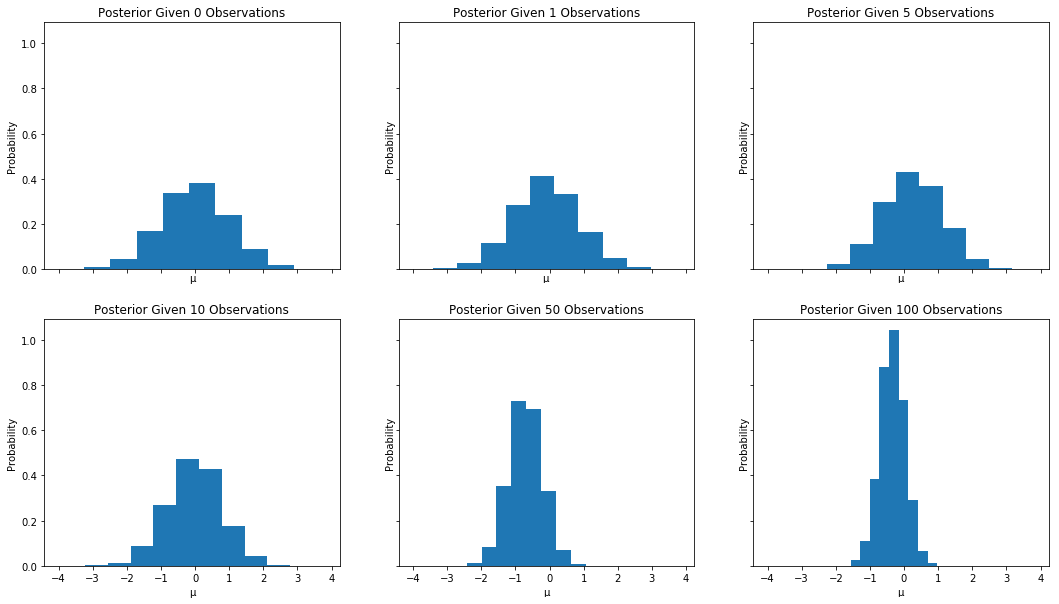

In [13]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=[18, 10], sharex=True, sharey=True)
num_obs = [0, 1, 5, 10, 50, 100]

for i, (num, ax) in enumerate(zip(num_obs, axarr.flatten())):
    samp = np.random.normal(loc=map_params[num, 0], scale=map_params[num, 1], size=hist_size)
    ax.hist(samp, normed=True)
    ax.set_title("Posterior Given {} Observations".format(num))
    ax.set_ylabel("Probability")
    ax.set_xlabel("μ")
    
plt.show()

## Gaussian with Known Mean (estimating precision $τ$)

### Making data

In [14]:
# Ground truth
mu = 3
tau = 1/4
data_size = 100

# Data
X = np.random.normal(loc=mu, scale=np.sqrt(1/tau), size=data_size)

# Number of samples used to plot histograms
hist_size = 10000

### Plotting priors

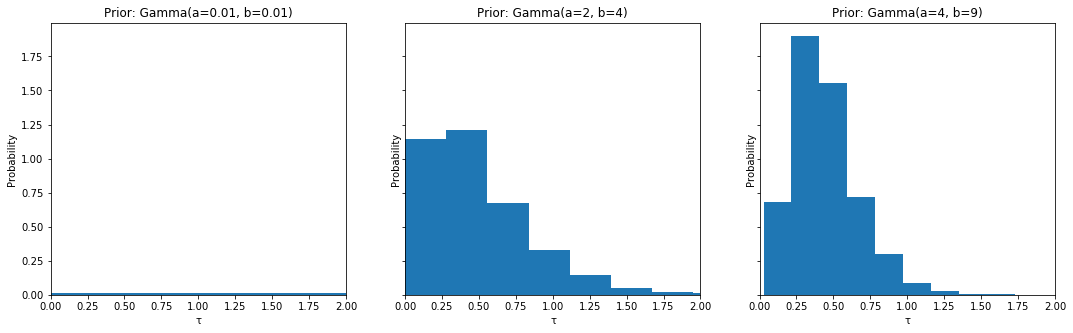

In [15]:
# 3 sets of hyperparameters
hyperparams = [(0.01, 0.01), (2, 4), (4, 9)]

fig, axarr = plt.subplots(nrows=1, ncols=len(hyperparams), figsize=[18, 5], sharex=True, sharey=True)
priors = np.empty(shape=[hist_size, len(hyperparams)])

for i, ((a, b), ax) in enumerate(zip(hyperparams, axarr)):
    # NumPy uses k and theta and not alpha and beta. The 1/ is to compensate for this
    priors[:, i] = np.random.gamma(shape=a, scale=1/b, size=hist_size)
    ax.hist(priors[:, i], normed=True)
    ax.set_xlim([0, 2])
    ax.set_title("Prior: Gamma(a={0}, b={1})".format(a, b))
    ax.set_ylabel("Probability")
    ax.set_xlabel("τ")

plt.show()

### MAP and ML estimation

In [16]:
# MAP
map_params = np.empty(shape=[len(X)+1, len(hyperparams)*len(hyperparams[0])])
map_params[0,:] = list(itertools.chain(*hyperparams))

for i, x in enumerate(X):
    # Update rule for Gaussian model with Gamma prior for tau. Online learning.
    map_params[i+1, ::2] = map_params[i, ::2] + 1/2
    map_params[i+1, 1::2] = map_params[i, 1::2] + 0.5*(x - mu)**2

# Expectation of Gamma(a,b) = a/b
map_ests = map_params[:, ::2] / map_params[:, 1::2]

In [17]:
# ML
ml_ests = np.empty(shape=[len(X), 1])

for i, x in enumerate(X):
    ml_ests[i] = 1/(np.sum((X[:i+1] - mu)**2)/(i+1))

### Plotting mean squared error

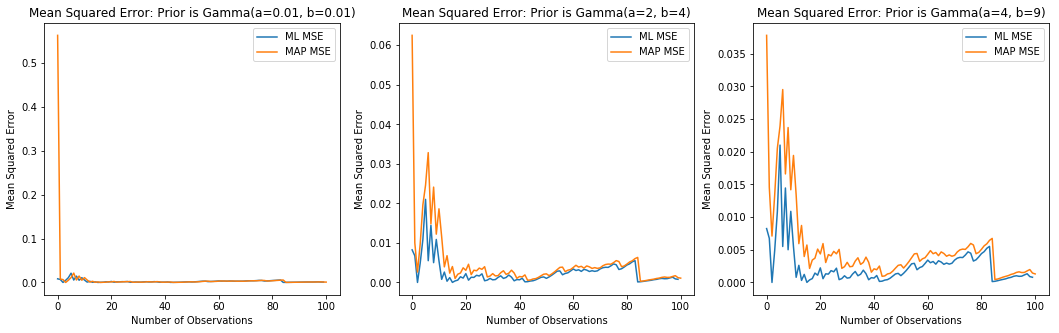

In [18]:
fig, axarr = plt.subplots(nrows=1, ncols=len(hyperparams), figsize=[18, 5], sharex=True)
ml_mean_sq_err = (ml_ests - tau)**2
map_mean_sq_err = (map_ests - tau)**2

for i, (ax, (a, b)) in enumerate(zip(axarr, hyperparams)):
    ax.plot(ml_mean_sq_err, label='ML MSE')
    ax.plot(map_mean_sq_err[:, i], label='MAP MSE')
    ax.set_title("Mean Squared Error: Prior is Gamma(a={0}, b={1})".format(a, b))
    ax.legend()
    ax.set_ylabel("Mean Squared Error")
    ax.set_xlabel("Number of Observations")

plt.show()

### Plotting posteriors for various observations

We use the first set of hyperparameters in `hyperparams` (i.e. a $Gamma(0.01, 0.01)$ prior) to illustrate this.

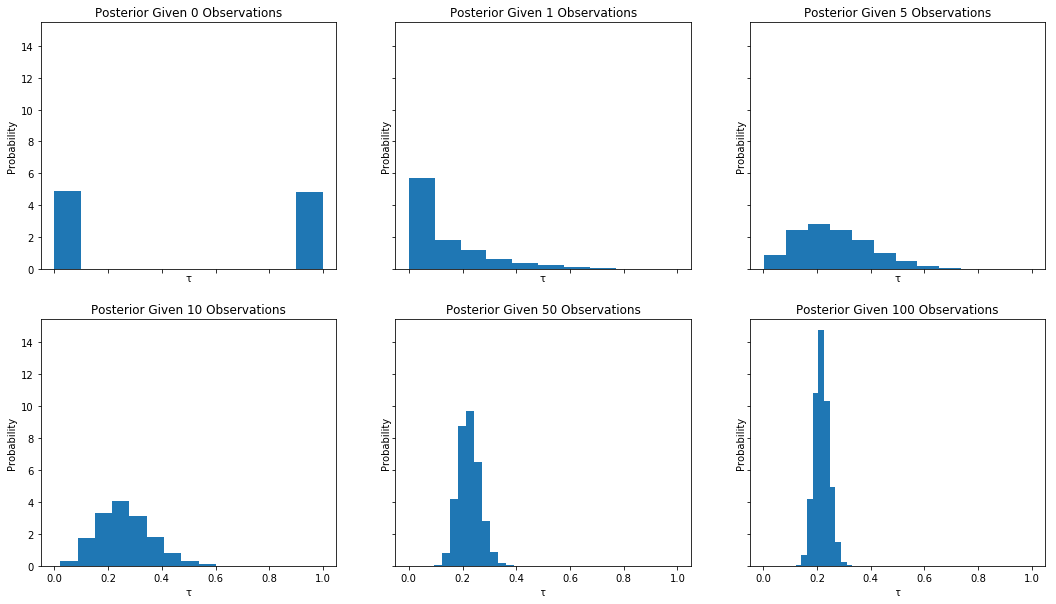

In [19]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=[18, 10], sharex=True, sharey=True)
num_obs = [0, 1, 5, 10, 50, 100]

for i, (num, ax) in enumerate(zip(num_obs, axarr.flatten())):
    foo = np.random.beta(a=map_params[num, 0], b=map_params[num, 1], size=hist_size)
    ax.hist(foo, normed=True)
    ax.set_title("Posterior Given {} Observations".format(num))
    ax.set_ylabel("Probability")
    ax.set_xlabel("τ")
    
plt.show()